<div style="max-width:66ch;">

# Lecture notes - XGBoost

This is the lecture note for **XGBoost**

<p class = "alert alert-info" role="alert"><b>Note</b> that this lecture note gives a brief introduction to XGBoost. I encourage you to read further about XGBoost. </p>

Read more:

- [sklearn estimator interface - xgboost documentation](https://xgboost.readthedocs.io/en/latest/python/sklearn_estimator.html)
- [XGBoost tutorial - xgboost documentation](https://xgboost.readthedocs.io/en/latest/tutorials/index.html)
- [gradient boosting - wikipedia](https://en.wikipedia.org/wiki/Gradient_boosting)
- [how to train XGBoost in Python - Lianne and Justing (2023)](https://www.youtube.com/watch?v=aLOQD66Sj0g)
- [Target Encoder - Category Encoders](https://contrib.scikit-learn.org/category_encoders/targetencoder.html)
- [scikit-optimize documentation](https://scikit-optimize.github.io/stable/)
- [Scikit-learn hyperparameter search wrapper - Shcherbatyi (2017) et. al.](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html)
- [BayesSearchCV - scikit-optimize](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)

</div>


<div style="max-width:66ch;">

## Setup
 


</div>

In [83]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder


df = pd.read_csv("../data/Heart.csv", index_col = 0)
df.dropna(inplace=True)
df.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [84]:
df_dummies = pd.get_dummies(df, drop_first=True)
X, y = df_dummies.drop("AHD_Yes", axis=1), df_dummies["AHD_Yes"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train.head()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_normal,Thal_reversable
278,39,0,138,220,0,0,152,0,0.0,2,0.0,True,False,False,True,False
263,60,0,150,240,0,0,171,0,0.9,1,0.0,False,False,True,True,False
31,69,0,140,239,0,0,151,0,1.8,1,2.0,False,False,True,True,False
23,58,1,120,284,0,2,160,0,1.8,2,0.0,False,True,False,True,False
282,47,1,130,253,0,0,179,0,0.0,1,0.0,True,False,False,True,False


<div style="max-width:66ch;">

## XGBoost
 
XGBoost or eXtreme Gradient Boosting uses ensemble learning, which combines several decision trees and boosting. The boosting works in the way that the decision trees are trained sequentially, where a new model focuses on previous models misclassified data points. It uses gradient descent to minimize the loss function and has regularization to decrease variance and increase bias, thus decreasing overfitting.

We setup a pipeline in sklearn, where we can put the XGBoost algorithm, so that we can use sklearn's API for training. Also we'll use scikit-optimize in order to use bayesian optimization for hyperparameter tuning. 

</div>

In [85]:
pipe = Pipeline(steps=[("clf", xgb.XGBClassifier(random_state=42))])
pipe

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

<div style="max-width:66ch;">

### Hyperparameter tuning
 
Define a search space and then use bayesian optimization from scikit-optimize to tune hyperparameters. It uses cross-validation in its tuning, but unlike gridsearch doesn't exhaustively search all combinations. Instead it uses past evaluations to make a probabilistic mapping of hyperparameters.

</div>

In [86]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

search_space = {
    "clf__max_depth": Integer(2, 8),
    "clf__learning_rate": Real(0.001, 1.0, prior="log-uniform"),
    "clf__subsample": Real(0.5, 1),
    "clf__colsample_bytree": Real(0.5, 1.0),
    "clf__colsample_bylevel": Real(0.5, 1.0),
    "clf__colsample_bynode": Real(0.5, 1.0),
    "clf__reg_alpha": Real(0, 10.0),
    "clf__reg_lambda": Real(0, 10.0),
    "clf__gamma": Real(0, 10.0),
}

# accuracy not good if dataset is imbalanced
optimizer = BayesSearchCV(pipe, search_space, cv=3, n_iter=10, scoring="accuracy", random_state=42)


In [87]:
optimizer.fit(X_train, y_train)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=None,
                                                       interaction_constraints=...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1, prior='uniform', transform='normalize')})

In [88]:
optimizer.best_estimator_

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.705051979426657,
                               colsample_bynode=0.8638628715886625,
                               colsample_bytree=0.966433999423917, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=3.1579959348704874,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.10243393225105074, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])

In [89]:
print("Scores")
print(f"score metrics for training data: {optimizer.best_score_=:.2f}")
print(f"score metrics for test data: {optimizer.score(X_test, y_test)=:.2f}")


Scores
score metrics for training data: optimizer.best_score_=0.78
score metrics for test data: optimizer.score(X_test, y_test)=0.88


In [90]:
y_pred = optimizer.predict(X_test)
y_pred

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1])

In [91]:
optimizer.predict_proba(X_test)[:5]

array([[0.72569364, 0.27430636],
       [0.5870408 , 0.41295925],
       [0.8102418 , 0.18975817],
       [0.3898818 , 0.6101182 ],
       [0.79190314, 0.20809683]], dtype=float32)

<div style="max-width:66ch;">

## Evaluation

</div>

              precision    recall  f1-score   support

       False       0.91      0.89      0.90        36
        True       0.84      0.88      0.86        24

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



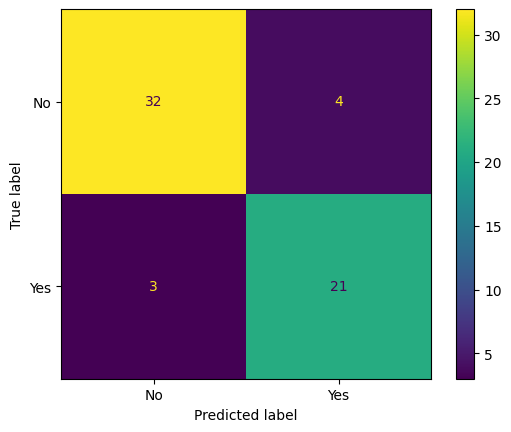

In [92]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_classification(y_test, y_pred, labels = ["No", "Yes"]):
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=labels).plot()

evaluate_classification(y_test, y_pred)

<div style="max-width:66ch;">

## Evaluation

</div>

In [93]:
optimizer.best_estimator_.steps[0]

('clf',
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=0.705051979426657,
               colsample_bynode=0.8638628715886625,
               colsample_bytree=0.966433999423917, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=3.1579959348704874,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.10243393225105074,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=4, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...))

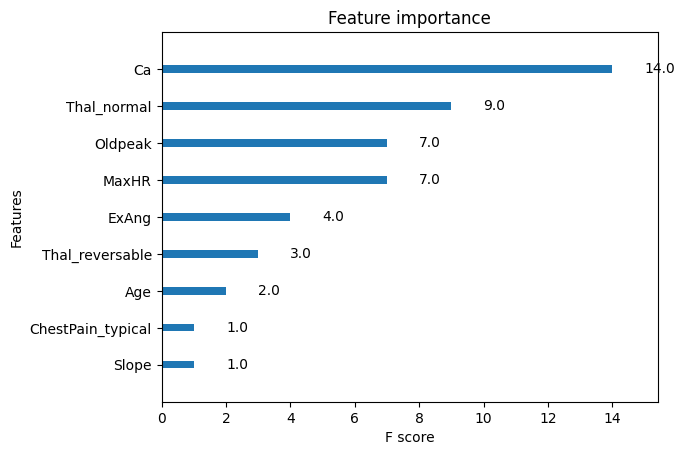

In [94]:
from xgboost import plot_importance
xgboost_model = optimizer.best_estimator_.steps[0][1]
plot_importance(xgboost_model)
plt.grid(False)

<div style="max-width:66ch;">

## Summary

In this lecture we've covered XGBoost, which is an extremely strong algorithm for tabular data, and in many times the state of the art algorithm for tabular data, both for regression and classification. We showed a Bayesian optimization approach to hyperparameter tune, instead of the exhaustive gridsearch that we've worked with before.

</div>

<div style="background-color: #FFF; color: #212121; border-radius: 1px; width:22ch; box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px; display: flex; justify-content: center; align-items: center;">
<div style="padding: 1.5em 0; width: 70%;">
    <h2 style="font-size: 1.2rem;">Kokchun Giang</h2>
    <a href="https://www.linkedin.com/in/kokchungiang/" target="_blank" style="display: flex; align-items: center; gap: .4em; color:#0A66C2;">
        <img src="https://content.linkedin.com/content/dam/me/business/en-us/amp/brand-site/v2/bg/LI-Bug.svg.original.svg" width="20"> 
        LinkedIn profile
    </a>
    <a href="https://github.com/kokchun/Portfolio-Kokchun-Giang" target="_blank" style="display: flex; align-items: center; gap: .4em; margin: 1em 0; color:#0A66C2;">
        <img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" width="20"> 
        Github portfolio
    </a>
    <span>AIgineer AB</span>
<div>
</div>
